In [23]:
import os 
import glob
join = os.path.join
from djccx.read_dat import read_dat
import numpy as np
from djccx.frd.readfrd import readfrd
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt


In [24]:
params_composite ={
    "r"         :  0.25,
    "h"         :  0.65,
    "z0"        :  2.82/2,
    "density"   : 8,
    "interface_factor"  :  1.2,
    "with_interface"    : False,
    "mirror"            : True,
    "check_jacobian"    : False,
}

params_ccx = {
    "epsilon" : 0.1,
}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [25]:
def compute_vol_frac(dat_path):
    dat = read_dat(dat_path)
    vols = [ idat["df"]["volume"].sum() for idat in dat]
    vT = vols[1]
    v_yarns = vols[0]/vT
    v_matrix = 1 - v_yarns 
    return {
        "yarns"  : v_yarns,
        "matrix" : v_matrix,
    }

In [26]:
r_span = np.linspace(0.15 ,0.25,3)
r_span

array([0.15, 0.2 , 0.25])

In [27]:
frd_files = glob.glob(join("output","r_*","ccx","*","*.frd"),recursive=True)
dat_files = glob.glob(join("output","r_*","ccx","*","*.dat"),recursive=True)

In [28]:
designs = [ os.path.split(os.path.split(f)[0])[1] for f in frd_files]
designs = list(designs)
designs

['SX_smooth', 'SY_smooth', 'SX_smooth', 'SY_smooth', 'SX_smooth', 'SY_smooth']

In [29]:
ancho = params_composite["z0"] + 0.5*params_composite["h"]
largo = 10 
A = ancho*largo

def compute_Fapl(iffiles):
    ifrd = readfrd(iffiles)
    df = ifrd["data"]
    Fapl = np.sum(df["F2"]*(df["y"] > df["y"].mean()))

    return Fapl

Fapl = [compute_Fapl(f) for f in frd_files]
Sapl = [f/A for f in Fapl]
E_eff = [s / params["ccx"]["epsilon"] for s in Sapl]

In [30]:
vfracs = [compute_vol_frac(f) for f in dat_files]

In [31]:
vfracs

[{'yarns': np.float64(0.022509073149375225),
  'matrix': np.float64(0.9774909268506248)},
 {'yarns': np.float64(0.022509073243223092),
  'matrix': np.float64(0.977490926756777)},
 {'yarns': np.float64(0.03133271097161987),
  'matrix': np.float64(0.9686672890283802)},
 {'yarns': np.float64(0.031332711102041465),
  'matrix': np.float64(0.9686672888979585)},
 {'yarns': np.float64(0.04175474967730135),
  'matrix': np.float64(0.9582452503226987)},
 {'yarns': np.float64(0.041754749275240956),
  'matrix': np.float64(0.9582452507247591)}]

In [32]:
from validation.experimental import carbonfiber,resina,nucleo

carbon = carbonfiber()
Ecarbon_MPa = carbon["carbon"].iloc[0]["Young Modulus (GPa)"]*1e3
resina = resina()
nucleo = nucleo()

In [33]:
def analytical(r):
    v_y  = r["yarns"]
    v_m  = r["matrix"]

    E_y = Ecarbon_MPa
    E_m = resina["young modulus [MPa]"]

    E_sy = 1/(v_y/E_y + v_m/E_m)
    v_sy = v_y + v_m
    return  E_sy*v_sy 

E_eff_analytical = [analytical(v) for v in vfracs]
v_carbon = [v["yarns"] for v in vfracs]

In [34]:
E_y = Ecarbon_MPa
E_m = resina["young modulus [MPa]"]
E_a = nucleo["young modulus [MPa]"]

In [35]:
print("Carbon",Ecarbon_MPa)
print("Resina",resina["young modulus [MPa]"])
print("Nucleo",nucleo["young modulus [MPa]"])

Carbon 230000.0
Resina 2549.7289999999994
Nucleo 800


In [36]:
v_carbon = np.array(v_carbon)

In [37]:
E_eff = np.array(E_eff)
E_eff_analytical = np.array(E_eff_analytical)

In [44]:
E_eff

array([ 925.98084735, 1282.50218391,  903.82332108, 1322.0106491 ,
        871.45023405, 1354.99843293])

In [38]:
v_carbon

array([0.02250907, 0.02250907, 0.03133271, 0.03133271, 0.04175475,
       0.04175475])

In [39]:
import pandas as pd

In [40]:
designs

['SX_smooth', 'SY_smooth', 'SX_smooth', 'SY_smooth', 'SX_smooth', 'SY_smooth']

In [41]:
df_results = pd.DataFrame({ 
    "design" : designs,
    "v_carbon" : v_carbon,
    "E_eff" : E_eff,
})

In [42]:
df_results

,design,v_carbon,E_eff
0,SX_smooth,0.022509,925.980847
1,SY_smooth,0.022509,1282.502184
2,SX_smooth,0.031333,903.823321
3,SY_smooth,0.031333,1322.010649
4,SX_smooth,0.041755,871.450234
5,SY_smooth,0.041755,1354.998433


Text(0.5, 1.0, '$t_l=0.65$ mm')

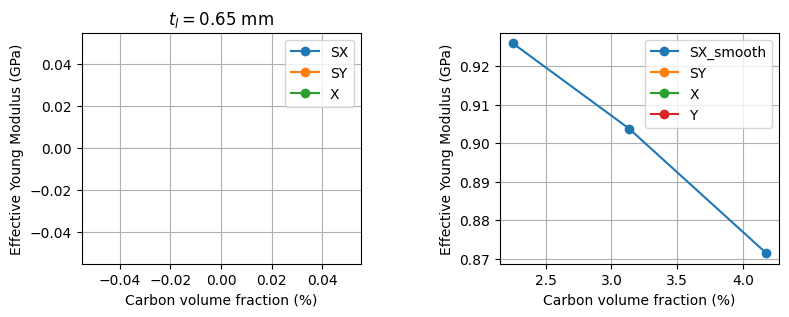

In [45]:
desing_unique = df_results["design"].unique()
fig = plt.figure(figsize=(9,3))
#
#paddding subplots
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,2,2)
for d in ["SX_smooth","SY","X","Y"]:
    df = df_results[df_results["design"] == d]
    plt.plot(100*df["v_carbon"],1e-3*df["E_eff"],label=d,marker="o")
plt.xlabel("Carbon volume fraction (%)")
plt.ylabel("Effective Young Modulus (GPa)")
plt.legend()
plt.grid()
# plt.ylim([0,None])

# ========================
plt.subplot(1,2,1)
for d in ["SX_smooth","SY","X"]:
    df = df_results[df_results["design"] == d]
    plt.plot(100*df["v_carbon"],1e-3*df["E_eff"],label=d,marker="o")
plt.xlabel("Carbon volume fraction (%)")
plt.ylabel("Effective Young Modulus (GPa)")
plt.legend()
plt.grid()
# plt.ylim([0,1.5])
h = params_composite["h"]
#
plt.title(f"$t_l={h}$ mm")
# ========================
